# Likelihood Analysis with fermipy

The python likelihood tools are a very powerful set of analysis tools that expand upon the command line tools provided with the Fermi Science Tools package. Not only can you perform all of the same likelihood analysis with the python tools that you can with the standard command line tools but you can directly access all of the model parameters. You can more easily script a standard analysis. There are also a few things built into the python tools that are not available from the command line like the calculation of upper limits.

There are many user contributed packages built upon the python backbone of the Science Tools and this thread will highlight the use of the [fermipy](http://fermipy.readthedocs.org) package.


This sample analysis is based on the PG 1553+113 analysis performed by the LAT team and described in [Abdo, A. A. et al. 2010, ApJ, 708, 1310](http://adsabs.harvard.edu/abs/2010ApJ...708.1310A). This tutorial assumes you have the most recent ScienceTools installed and [fermipy](http://fermipy.readthedocs.org) installed on top of it.  For instructions on installing fermipy and the Fermi ScienceTools you should consult the [fermipy Installation Instructions](http://fermipy.readthedocs.org/en/latest/install.html).  We will also make significant use of python, so you might want to familiarize yourself with python including matplotlib and other libraries (there's a beginner's guide at http://wiki.python.org/moin/BeginnersGuide). This tutorial also assumes that you've gone through the non-python based unbinned likelihood thread. 

## Get the Data

For this thread the original data were extracted from the [LAT data server](http://fermi.gsfc.nasa.gov/cgi-bin/ssc/LAT/LATDataQuery.cgi) with the following selections (these selections are similar to those in the paper):

* Search Center (RA,Dec) = (238.929,11.1901)
* Radius = 30 degrees
* Start Time (MET) = 239557417 seconds (2008-08-04T15:43:37)
* Stop Time (MET) = 256970880 seconds (2009-02-22T04:48:00)
* Minimum Energy = 100 MeV
* Maximum Energy = 300000 MeV

Once you exectute the query you can download the data and put it in your working directory.  You'll need to change the names of the files to match the filenames that the data server gave you.  Alternatively you can run with the following tarball which already contains the downloaded files as well as all of the ancillary files that will be generated for the analysis.  In this example the output of the analysis will go into a subdirectory called *pg1553*.

In [1]:
!wget -nc http://www.slac.stanford.edu/~mdwood/fermipy/pg1553.tar.gz
# Alternate download link
# wget -nc https://www.dropbox.com/s/heeft4xx0ibfk8c/pg1553.tar.gz
!tar xzf pg1553.tar.gz

File ‘pg1553.tar.gz’ already there; not retrieving.



### Make a file list

You'll then need to make a file list with the names of your input event files. You can either just make one with a text editor or do the following from the command line.

In [2]:
!ls -1 pg1553/*PH*.fits > pg1553/PG1553.lst

## Make a config file

fermipy bases its analysis on a configuration file (in [yaml](http://yaml.org) format).  We're just going to use a really simple config file for a standard analysis.  There are many many more options which you can use or you can modify these options after the fact within the analysis chain.


Make a config file named 'config.yaml' like the following.  For more details on the config file see [config.html](http://fermipy.readthedocs.org/en/latest/config.html).  You will probably need to customize this a bit since your files might not be in the same place or named the same.  The galactic and isotropic diffuse will need to be located on your system (they are included in the science tools or can be downloaded from the FSSC).  In the following example we set the path to these files with the environment variable FERMI_DIFFUSE_DIR.  If FERMI_DIFFUSE_DIR is not defined fermipy will look for the location of these files within the FSSC STs distribution. 

## Start the analysis

Next, you create an analysis script and run the setup steps which include running the selections and generating exposure maps etc.  This will take a bit.

This is where the magic happens.  fermipy will load the point source model, create your xml file for you, decide on all the appropriate cuts and binnings and just go.  All of this is configurable from python or from the config file.  And, if you need to rerun things, it's smart enough to not overwrite files if it doesn't need to.

### Load up some useful modules

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Import the GTAnalysis module from fermipy

You start by importing the module and then creating an instance of the analysis object from our config file.  When instantiating the analysis object we can override any options defined in the configuration file by passing keyword arguments to the object constructor.  Here we explicitly set the verbosity parameter to 3 (INFO) which supresses DEBUG output.  When we create the object, it spits out a bunch of information about all of the parameters that were used.  You can see there are many more options than the ones we chose.

In [4]:
from fermipy.gtanalysis import GTAnalysis

Plotter is MatPlotlib


/Users/mdwood/src/ScienceTools/x86_64-apple-darwin14.3.0/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [5]:
gta = GTAnalysis('pg1553/config.yaml',logging={'verbosity': 3})

2016-03-17 09:43:43 INFO     GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
This is fermipy version 0.6.7+2.gec74.dirty.


### The setup routine

This gets everything ready for the likelihood analysis including instantiating the pylikelihood object.  Note that fermipy will skip generating any ancillary files that already exist in the working directory.  In the sample tarball these files have already been produced in order to speed up this stage of the analysis.  If you want to see the behavior of fermipy when running from an empty working directory you can delete one or more of these files before running *setup*.

In [6]:
gta.setup()

2016-03-17 09:43:59 INFO     GTAnalysis.setup(): Running setup
2016-03-17 09:43:59 INFO     GTBinnedAnalysis.setup(): Running setup for Analysis Component: 00
2016-03-17 09:44:10 INFO     GTBinnedAnalysis.setup(): Finished setup for Analysis Component: 00
2016-03-17 09:44:10 INFO     GTAnalysis.setup(): Initializing source properties
2016-03-17 09:44:22 INFO     GTAnalysis.setup(): Finished setup


Before proceeding with the analysis we'll have a quick look at the files that are produced by the setup function.

In [7]:
ls pg1553/*fits

pg1553/L1511031432171D651E7F63_PH00.fits  pg1553/bexpmap_00.fits                    pg1553/ccube_00.fits                      pg1553/mcube_fit0.fits
pg1553/L1511031432171D651E7F63_PH01.fits  pg1553/bexpmap_roi_00.fits                pg1553/ft1_00.fits                        pg1553/mcube_fit0_00.fits
pg1553/L1511031432171D651E7F63_SC00.fits  pg1553/ccube.fits                         pg1553/ltcube_00.fits                     pg1553/srcmap_00.fits


Here is a brief explanation of the contents of each file and its role in the analysis:

* **ft1_00.fits**: Event list.  This is generated by running gtselect and gtmktime on our input file list.
* **bexpmap_00.fits**: All-sky binned exposure map.  This map is interpolated to create an exposure model when generating the srcmap file.
* **bexpmap_roi_00.fits**: Binned exposure map for the ROI.  This file is only provided for visualization purposes in order to have an exposure map with the same binning as the data and model maps.
* **ccube_00.fits**: Counts cube for the ROI.
* **ltcube_00.fits**: Livetime cube.  This contains a map of the livetime for this observation over the whole sky as a function of incidence angle.
* **srcmap_00.fits**: Source map cube.  This file contains maps for each of the components in the ROI after convolution with exposure and the PSF.  Note that energy dispersion is applied at run-time.

Note that all of the files have a numerical suffix '00'.  This is the analysis component index.  In a multi-component analysis there would be instances of all of the above files for each analysis component.  The files with no component index are co-added maps that are provided for visualization purposes.

To see example of one of these files we can open and plot the counts cube file.  This is a 3D cube that contains the distribution of events as a function of energy and two spatial coordinates.  In the example below we sum over the energy dimension of the cube to make a 2-D sky image.

Filename: pg1553/ccube.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      24   (100, 100, 28)   float64   


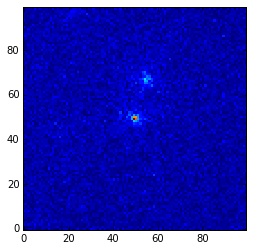

In [8]:
import astropy.io.fits as pyfits

h = pyfits.open('pg1553/ccube.fits')
h.info()
counts = h[0].data
counts.shape
plt.figure()
plt.imshow(np.sum(counts,axis=0),interpolation='nearest',origin='lower')

We can now inspect the state of the ROI prior with the print_roi() method.

In [9]:
gta.print_roi()

name                SpatialModel   SpectrumType     offset        ts       Npred
--------------------------------------------------------------------------------
3FGL J1555.7+1111   PointSource    LogParabola       0.000       nan       923.2
3FGL J1553.5+1256   PointSource    LogParabola       1.833       nan       655.4
3FGL J1603.7+1106   PointSource    PowerLaw          1.976       nan       122.7
3FGL J1552.1+0852   PointSource    PowerLaw          2.482       nan        90.2
3FGL J1608.6+1029   PointSource    PowerLaw          3.252       nan       531.6
3FGL J1541.8+1105   PointSource    PowerLaw          3.411       nan       155.4
3FGL J1546.0+0818   PointSource    PowerLaw          3.753       nan        38.6
3FGL J1548.4+1455   PointSource    PowerLaw          4.134       nan       187.8
3FGL J1541.6+1414   PointSource    PowerLaw          4.596       nan        34.4
3FGL J1611.9+1404   PointSource    PowerLaw          4.888       nan        81.2
3FGL J1540.8+1449   PointSou

Additional details about an individual source can be retrieved by printing the corresponding source object.  Here we use the bracket operator to return the properties of PG1553. 

In [10]:
print(gta.roi['3FGL J1555.7+1111'])

Name           : 3FGL J1555.7+1111
Associations   : ['3FGL J1555.7+1111', 'PG 1553+113', '1FHL J1555.7+1111', '2FGL J1555.7+1111']
RA/DEC         :    238.936/    11.194
GLON/GLAT      :     21.918/    43.960
TS             : nan
Npred          : 923.16
Flux           : 5.32e-08 +/-      nan
EnergyFlux     : 0.000134 +/-      nan
SpatialModel   : PointSource
SpectrumType   : LogParabola
Spectral Parameters
alpha          :      1.604 +/-        nan
beta           :    0.03884 +/-        nan
norm           :  4.825e-12 +/-        nan
Eb             :       1491 +/-        nan


## Do the likelihood fitting

Now that all of the ancillary files have been generated, we can move on to the actual fitting.  The first thing you should do is free some of the sources since all of the sources are initially fixed.  We'll just free those sources in the center region.

In [11]:
# Free Normalization of all Sources within 3 deg of ROI center
gta.free_sources(distance=3.0,pars='norm')

# Free all parameters of isotropic and galactic diffuse components
gta.free_source('galdiff')
gta.free_source('isodiff')

In this simple anlaysis we are leaving the spectral shapes of sources fixed but we're going to free the spectral shape of the source we care about.  

In [12]:
gta.free_source('3FGL J1555.7+1111')

Now, actually do the fit.  The software does its best to get the fit to converge by running the fit several times.

In [13]:
gta.fit()

{'covariance': array([[  1.29959110e+00,   1.16583118e-02,  -1.12020317e-03,
          -2.08209565e-03,   3.42845397e-04,   2.26269766e-02,
          -1.09763707e-03,   5.67061595e-05,  -6.97912526e-03],
        [  1.16583118e-02,   5.45844909e-02,  -7.34386493e-04,
          -1.09417030e-03,   1.60344963e-04,   1.16947684e-04,
           1.06429930e-04,  -2.61161278e-04,  -1.85723576e-03],
        [ -1.12020317e-03,  -7.34386493e-04,   8.81162819e-04,
           1.14122654e-04,   1.14683835e-04,  -1.58780049e-03,
          -1.04298522e-04,   5.28338553e-05,  -9.54844613e-06],
        [ -2.08209565e-03,  -1.09417030e-03,   1.14122654e-04,
           1.13981278e-03,  -1.69554960e-04,  -2.48227321e-03,
           4.34921541e-05,  -7.28947277e-05,  -8.69504903e-05],
        [  3.42845397e-04,   1.60344963e-04,   1.14683835e-04,
          -1.69554960e-04,   1.32269794e-04,   3.86089929e-04,
          -3.03501036e-05,   2.37982840e-05,   3.36523309e-05],
        [  2.26269766e-02,   1.16947

We can inspect the results of the fit by printing the source object for PG1553.

In [14]:
print(gta.roi['3FGL J1555.7+1111'])

Name           : 3FGL J1555.7+1111
Associations   : ['3FGL J1555.7+1111', 'PG 1553+113', '1FHL J1555.7+1111', '2FGL J1555.7+1111']
RA/DEC         :    238.936/    11.194
GLON/GLAT      :     21.918/    43.960
TS             : 3004.00
Npred          : 1115.62
Flux           : 6.16e-08 +/- 4.25e-09
EnergyFlux     : 0.000196 +/-  2.1e-05
SpatialModel   : PointSource
SpectrumType   : LogParabola
Spectral Parameters
alpha          :       1.53 +/-    0.03376
beta           :    0.04392 +/-     0.0115
norm           :  6.112e-12 +/-  2.968e-13
Eb             :       1491 +/-        nan


You can then save the state of the roi to a yaml (and npy) file for reference later.  The write_roi function does this.  The first argument is a string that will be prepended to the names of the output files generated by this method.

In [15]:
gta.write_roi('fit0')

2016-03-17 09:44:48 INFO     GTBinnedAnalysis.write_xml(): Writing /Users/mdwood/fermi/fermipy/notebooks/pg1553/fit0_00.xml...
2016-03-17 09:44:48 INFO     GTBinnedAnalysis.generate_model_map(): Generating model map for component 00.
2016-03-17 09:44:53 INFO     GTAnalysis.write_roi(): Writing /Users/mdwood/fermi/fermipy/notebooks/pg1553/fit0.npy...
2016-03-17 09:44:53 INFO     GTAnalysis.write_roi(): Writing /Users/mdwood/fermi/fermipy/notebooks/pg1553/fit0.yaml...
/Users/mdwood/src/ScienceTools/x86_64-apple-darwin14.3.0/lib/python2.7/site-packages/matplotlib/colors.py:1178: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)
/Users/mdwood/src/ScienceTools/x86_64-apple-darwin14.3.0/lib/python2.7/site-packages/matplotlib/colorbar.py:588: RuntimeWarning: invalid value encountered in greater
  inrange = (ticks > -0.001) & (ticks < 1.001)
/Users/mdwood/src/ScienceTools/x86_64-apple-darwin14.3.0/lib/python2.7/site-packages/matplotlib/colorbar.py:588: Runtim

There are a lot of diagnostic plots also saved at the same time.  

In [16]:
ls -l pg1553/*.png

-rw-r--r--  1 mdwood  staff  48738 Mar 17 09:44 pg1553/fit0_counts_map_2.000_5.477.png
-rw-r--r--  1 mdwood  staff  16647 Jan 20 11:09 pg1553/fit0_counts_map_comp_xproj_2.000_5.477.png
-rw-r--r--  1 mdwood  staff  16816 Jan 20 11:09 pg1553/fit0_counts_map_comp_yproj_2.000_5.477.png
-rw-r--r--  1 mdwood  staff  19370 Mar 17 09:44 pg1553/fit0_counts_map_xproj_2.000_5.477.png
-rw-r--r--  1 mdwood  staff  19686 Mar 17 09:44 pg1553/fit0_counts_map_yproj_2.000_5.477.png
-rw-r--r--  1 mdwood  staff  41393 Mar 17 09:44 pg1553/fit0_counts_spectrum.png
-rw-r--r--  1 mdwood  staff  40513 Mar 17 09:44 pg1553/fit0_model_map_2.000_5.477.png
-rw-r--r--  1 mdwood  staff  38288 Jan 20 11:09 pg1553/fit0_model_map_2.000_5.477_00.png


In [17]:
from IPython.display import Image, display
from glob import glob

In [18]:
pngs = glob('*.png')

In [19]:
for png in pngs:
    my_image = Image(png)
    display(my_image)

### Reading in the results

Since the results are saved, you can load them back up at any point (you can also get to these within python).  Here we retrieve the analysis results from the output numpy file. 

In [20]:
c = np.load('pg1553/fit0.npy').flat[0]

Here's all the info that you have access to.

In [21]:
c['sources']['3FGL J1555.7+1111'].keys()

['eflux100',
 'Source_Name',
 'flux10000',
 'flux100_ul95',
 'spatial_pars',
 'SpatialType',
 'radec',
 'flux10000_ul95',
 'flux100',
 'localize',
 'dfde100_index',
 'offset_dec',
 'flux',
 'dfde1000',
 'flux_ul95',
 'ts',
 'class',
 'lnlprofile',
 'params',
 'offset_glat',
 'dfde100',
 'eflux10000',
 'offset_ra',
 'ra',
 'Spatial_Filename',
 'SpatialModel',
 'offset_glon',
 'glon',
 'model_flux',
 'SpatialWidth',
 'eflux1000',
 'DEJ2000',
 'eflux',
 'glat',
 'dfde',
 'covar',
 'SpectrumType',
 'Npred',
 'assoc',
 'eflux10000_ul95',
 'spectral_pars',
 'offset',
 'eflux100_ul95',
 'dfde10000',
 'dfde1000_index',
 'eflux1000_ul95',
 'name',
 'flux1000_ul95',
 'flux1000',
 'SourceType',
 'extension',
 'model_counts',
 'catalog',
 'eflux_ul95',
 'RAJ2000',
 'sed',
 'pivot_energy',
 'dec',
 'dfde10000_index']

Let's take a look at the flux, spectral parameters, and TS.

In [22]:
c['sources']['3FGL J1555.7+1111']['flux']

array([  6.15709418e-08,   4.25340385e-09])

In [23]:
c['sources']['3FGL J1555.7+1111']['params']

{'Eb': array([ 1491.38049316,            nan]),
 'alpha': array([ 1.53040829,  0.03376111]),
 'beta': array([ 0.04391581,  0.01150086]),
 'norm': array([  6.11195780e-12,   2.96843868e-13]),
 'spectrum_type': 'LogParabola'}

In [24]:
c['sources']['3FGL J1555.7+1111']['ts']

3003.9973096413305

The SED is in there as well.  We can plot it.

In [25]:
E = np.array(c['sources']['3FGL J1555.7+1111']['model_flux']['ecenter'])
dfde = np.array(c['sources']['3FGL J1555.7+1111']['model_flux']['dfde'])
dfde_hi = np.array(c['sources']['3FGL J1555.7+1111']['model_flux']['dfde_hi'])
dfde_lo = np.array(c['sources']['3FGL J1555.7+1111']['model_flux']['dfde_lo'])

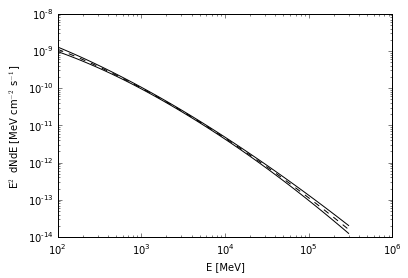

In [26]:
plt.loglog(10**E, (E**2)*dfde, 'k--')
plt.loglog(10**E, (E**2)*dfde_hi, 'k')
plt.loglog(10**E, (E**2)*dfde_lo, 'k')
plt.xlabel('E [MeV]')
plt.ylabel(r'E$^2$ dNdE [MeV cm$^{-2}$ s$^{-1}$]')
plt.show()

If you want SED points, there's a function for that.  There are lots of options for this which you can set in the config file or from keyword arguments of the function itself.

In [27]:
sed = gta.sed('3FGL J1555.7+1111')

2016-03-17 09:44:59 INFO     SEDGenerator.make_sed(): Computing SED for 3FGL J1555.7+1111
/Users/mdwood/fermi/fermipy/fermipy/utils.py:418: RuntimeWarning: invalid value encountered in absolute
  err_lo = np.abs(x0 - find_function_root(fn,x0,xval[0],0.5))
2016-03-17 09:45:49 INFO     SEDGenerator.make_sed(): Finished SED


You can save the state to the yaml file or you can just access it directly.  This is also the way to get at the dictionary for any individual source.

In [28]:
src = gta.roi['3FGL J1555.7+1111']

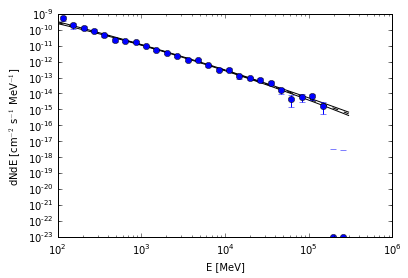

In [29]:
plt.loglog(10**E, dfde, 'k--')
plt.loglog(10**E, dfde_hi, 'k')
plt.loglog(10**E, dfde_lo, 'k')
plt.errorbar(10**np.array(src.data['sed']['ecenter'])
             ,src.data['sed']['dfde'], 
             yerr=src.data['sed']['dfde_err'], fmt ='o')
plt.xlabel('E [MeV]')
plt.ylabel(r'dNdE [cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]')
plt.show()

Looks like those last two points should be upper limits.  Let's plot those instead.

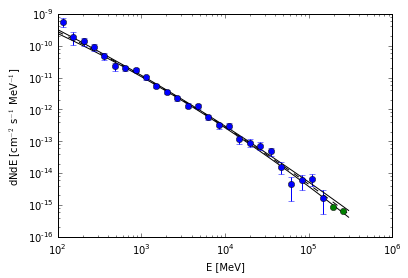

In [30]:
plt.loglog(10**E, dfde, 'k--')
plt.loglog(10**E, dfde_hi, 'k')
plt.loglog(10**E, dfde_lo, 'k')
plt.errorbar(10**np.array(src.data['sed']['ecenter'][:-2])
             ,src.data['sed']['dfde'][:-2], 
             yerr=src.data['sed']['dfde_err'][:-2], fmt ='o')
plt.plot(10**np.array(src.data['sed']['ecenter'][-2:])
             ,src.data['sed']['dfde_ul95'][-2:], 'o')
plt.xlabel('E [MeV]')
plt.ylabel(r'dNdE [cm$^{-2}$ s$^{-1}$ MeV$^{-1}$]')
plt.show()

### Summary

There is a lot of other functionality and you should look through the docs for more details.  You can also inspect the GTAnalysis object for some of these (like TS Maps, extension tests, and using event types).  Following threads cover some of the more advanced functionality of fermipy:

* [IC443](ic443.ipynb) : Analysis to measure the angular extension of the SNR IC443.
* [Draco](draco.ipynb) : DM upper limit analysis of the Draco dwarf spheroidal galaxy.